In [10]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import RFutils
import dask
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import cf_xarray as cfxr
import scipy.signal as signal
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve_triangular

import seaborn as sns
import matplotlib as mpl
import cmocean
import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec

import copy
import os

dask.config.set(**{'array.slicing.split_large_chunks': True})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data
Data comes from the 1pctCO2 experiment and is in terms of net radiative fluxes, not CO2 concentrations.

### Import Training Datasets

In [3]:
model_set = RFutils.model_test_set
plot = True

train_id = '1pctCO2'
print(f'Using {train_id} data for training.')

# Import required datasets
ERF, dN, EB_train_dict = {}, {}, {}
lambda_error = [-0.1,0,0.1]
ERF[train_id], dN[train_id], EB_train_dict[train_id], EB_ctrl_dict = RFutils.load_ERF_set(model_set, train_id, print_var = False, ssp = False, lambda_error = lambda_error)

Using 1pctCO2 data for training.
	 Loading NorESM2-LM data...
Error in lambda = -0.1
Error in lambda = 0
Error in lambda = 0.1
	 Loading MRI-ESM2-0 data...
Error in lambda = -0.1
Error in lambda = 0
Error in lambda = 0.1


### Regrid, Smooth, and Check Condition Number of Data

In [6]:
A = RFutils.A
ds_out = RFutils.ds_out

for m in dN[train_id]:
    dN[train_id][m] = RFutils.regrid_cmip(dN[train_id][m],ds_out)
    dN[train_id][m] = dN[train_id][m].weighted(A).mean(dim = ['lat','lon'])

for m in ERF[train_id]:
    ERF[train_id][m] = RFutils.regrid_cmip(ERF[train_id][m],ds_out)
    ERF[train_id][m] = ERF[train_id][m].weighted(A).mean(dim = ['lat','lon'])
    
    ERF_smooth = savgol_filter(ERF[train_id][m]['ERF'].values,100,3,mode='nearest')
    ERF[train_id][m].ERF.values = ERF_smooth
    
RFutils.check_data(ERF,train_id)

ValueError: dataset must include lon/lat or be CF-compliant

### Plot $F$ Profiles (Optional)

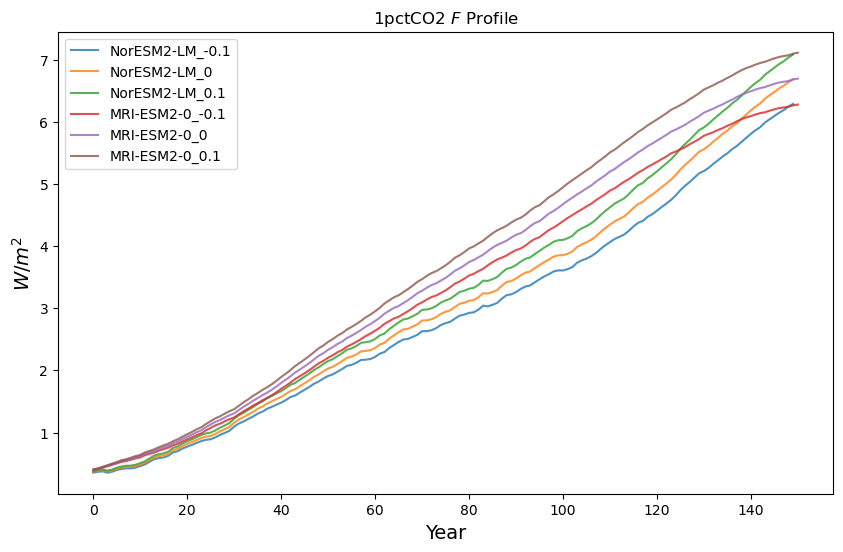

In [16]:
# Plot ERF Profiles (Optional)
if plot:
    ERFplot = copy.deepcopy(ERF)
    for m in ERFplot[train_id].keys():
        ERFplot[train_id][m] = ERFplot[train_id][m].assign_coords({'year':ERFplot[train_id][m].year - ERFplot[train_id][m].year[0]})

    ERF_ds = RFutils.concat_multirun(ERFplot[train_id], 'model')
    model_color = RFutils.model_color
    type_color = RFutils.type_color
    RFutils.plot_ERF_profile(ERF_ds, train_id, model_color, save_fig = False)

### Diagnose Green's Functions

In [22]:
savgol = True
ds_control, ds_exp, G_ds = RFutils.create_multimodel_GF_set(ERF, train_id, model_set, savgol, save_GF = False, sens = True)

if plot:
    RFutils.plot_mean_Greens(G_ds, train_id, overlay = True, save_fig = False)

Diagnosing GF for NorESM2-LM...


ValueError: max() arg is an empty sequence

### Save Individual Model Green's Functions

In [10]:
for m in G_ds.model:
    print(f'Saving {str(m.values)}...')
    G_ds.sel(model = m).to_netcdf(f'../Outputs/RF_Outputs/G_{train_id}_F_model_{str(m.values)}_ds.nc4')

Saving MIROC...


### Add New Models to Master Dataset

In [26]:
import os
G_master_ds = xr.open_dataset(f'../Outputs/RF_Outputs/G_{train_id}_F_all_ds.nc4')
G_master_new = xr.concat([G_master_ds,G_ds.to_dataset(name='__xarray_dataarray_variable__')],'model',coords='minimal')
os.remove(f'../Outputs/RF_Outputs/G_{train_id}_F_all_ds.nc4')
G_master_new.to_netcdf(f'../Outputs/RF_Outputs/G_{train_id}_F_all_ds.nc4')

### Save Master Model DataSet (Only Needed on First Run)

In [9]:
#G_ds.to_netcdf(f'../Outputs/RF_Outputs/G_{train_id}_F_all_ds.nc4')

In [10]:
#G_master_ds = xr.open_dataset(f'../Outputs/RF_Outputs/G_{train_id}_RF_all_ds.nc4')
#RFutils.plot_mean_Greens(G_master_ds, train_id, overlay = True, save_fig = False)

In [13]:
import os
model_reset_dict = RFutils.model_1pctCO2_dict
reset_models = {}
for m in model_reset_dict.keys():
    if m == 'MIROC':
        continue
    G_model = xr.open_dataset(f'../Outputs/RF_Outputs/G_{train_id}_F_model_{m}_ds.nc4')
    reset_models[m] = G_model
G_reset = RFutils.concat_multirun(reset_models, name='model')

In [23]:
G_master_new = xr.concat([G_reset,G_ds.to_dataset(name='__xarray_dataarray_variable__')],'model',coords='minimal')
os.remove(f'../Outputs/RF_Outputs/G_{train_id}_F_all_ds.nc4')
G_master_new.to_netcdf(f'../Outputs/RF_Outputs/G_{train_id}_F_all_ds.nc4')